In this quick notebook, we illustrate a simple case of ZNE error mitigation using global folds in Qiskit. 

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
 
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

We first as an example of making a circuit in qiskit, we first design a circuit to obtain a GHZ state $|\psi \rangle \frac{1}{\sqrt{2}}|0000 \rangle + \frac{1}{\sqrt{2}}|1111 \rangle$. The circuit below prepares the GHZ state by applying a Hadarmard gate to the first qubit and then applying three concsecutive CNOT gates to qubits $(0,1), (1,2), (1,3)$ respectively. We then add a measurement command to obtain counts.

In [227]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)
 
# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


The following code displays the measurement outcomes of measuring in states $|000 \rangle$ and $|111 \rangle$ in terms of a histogram. Since $tr(|\psi \rangle \langle \psi| |000 \rangle \langle 000 |) = 1/2$ and $tr(|\psi \rangle \langle \psi| |111 \rangle \langle 111 |) = 1/2$, we should roughly see this in our histogram. This model is without noise.

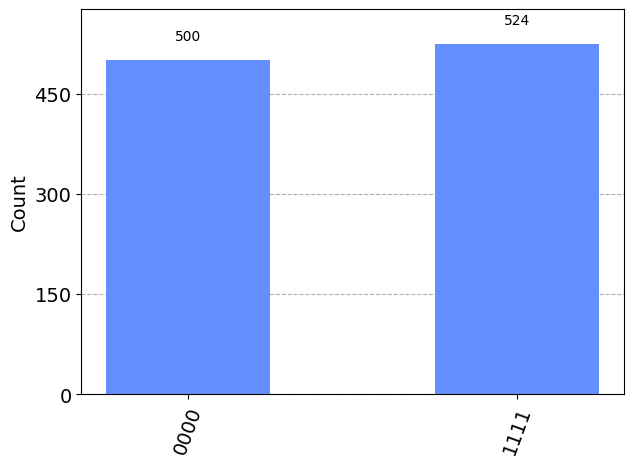

In [6]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

We now introduce a noise model with noise parameter $\tau$. In our model, we introduce noise into the CNOT gates. Though we did not do this, one could also add noise into the Hadamard gate by adding an error into the rotation gates. 

In [160]:
# Create an empty noise model
noise_model = NoiseModel()
 
# Add depolarizing error
error = depolarizing_error(0.15, 2)
noise_model.add_all_qubit_quantum_error(error, ['cx'])
 
# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  All-qubits errors: ['cx']


We now simulate the noisy circuit

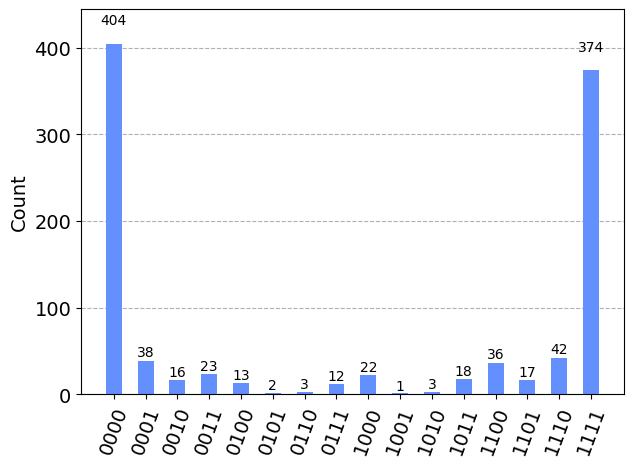

In [228]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_model)
 
# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
circ_tnoise = passmanager.run(circ)
 
# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)
 
# Plot noisy output
plot_histogram(counts_bit_flip)


We now define a function that defines a circuit. We apply global folds to this circuit, meaning if our state evolves according to $U|\psi_{0} \rangle$, we consider the circuit given by $UU^{\dagger}U|\psi_{0} \rangle$. Each fold theoretically should be the same as multiplying by an identity since $UU^{\dagger} = I$ but this increases the depth of the circuit and therefore the noise.

In [111]:
#write a function that displays the circuit in terms of number of folds:
import copy
def basiccircuit(num):
    n_qubits = num
    circ = QuantumCircuit(n_qubits)
     
    # Test Circuit
    circ.h(0)
    for qubit in range(n_qubits - 1):
        circ.cx(qubit, qubit + 1)
    return circ

print(basiccircuit(4))
    
def basiccircuitfold(n_qubits,n_folds):
    circ = basiccircuit(n_qubits)
    circ.barrier()
    for i in range(n_folds):
        for qubit in range(n_qubits-1,0,-1):
            circ.cx(qubit-1, qubit)
        circ.h(0)
        circ.barrier()
        circ.h(0)
        for qubit in range(n_qubits - 1):
            circ.cx(qubit, qubit + 1)
    return circ
        
print(basiccircuitfold(2,1))        





     ┌───┐               
q_0: ┤ H ├──■────────────
     └───┘┌─┴─┐          
q_1: ─────┤ X ├──■───────
          └───┘┌─┴─┐     
q_2: ──────────┤ X ├──■──
               └───┘┌─┴─┐
q_3: ───────────────┤ X ├
                    └───┘
     ┌───┐      ░      ┌───┐ ░ ┌───┐     
q_0: ┤ H ├──■───░───■──┤ H ├─░─┤ H ├──■──
     └───┘┌─┴─┐ ░ ┌─┴─┐└───┘ ░ └───┘┌─┴─┐
q_1: ─────┤ X ├─░─┤ X ├──────░──────┤ X ├
          └───┘ ░ └───┘      ░      └───┘


We now do ZNE for the Bell state $\frac{1}{\sqrt{2}}(|00 \rangle + |11\rangle)$. We apply folds and then extrapolate to get the zero noise estimate. 

In [112]:
#define a function to measure each state of circuit with noise model:
circ = basiccircuit(2)
# Create noisy simulator backend
def probabilities(counts):
    prob = []
    keys = list(counts.keys())
    for j in range(dim):
        if j in keys:
            prob.append(counts[j])
        else:
            prob.append(0)
    
    prob = np.array(prob)        
    prob = prob/np.sum(prob)
    return prob




def noisysimultation(circuit, noise_model):
    circuit.measure_all()
    sim_noise = AerSimulator(noise_model=noise_model)
     
    # Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
    circ_tnoise = passmanager.run(circ)
     
    # Run and get counts
    result_bit_flip = sim_noise.run(circ_tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts(0)
    #Define and return 
    return counts_bit_flip


Let's plot some histograms to see this effect

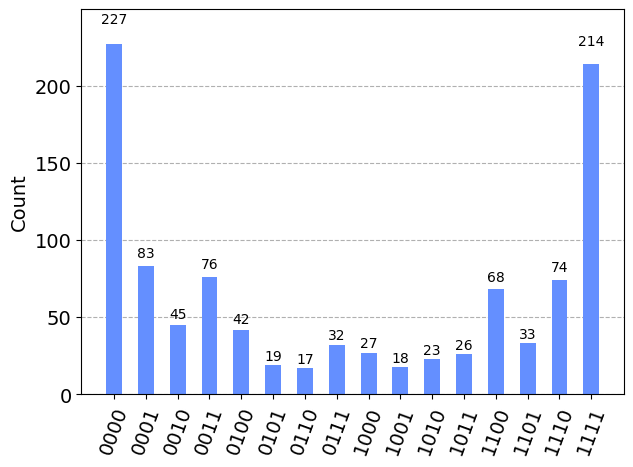

In [155]:
#One fold
circ = basiccircuitfold(4,1)
#print(noisysimultation(circ, noise_model))
plot_histogram(noisysimultation(circ, noise_model))

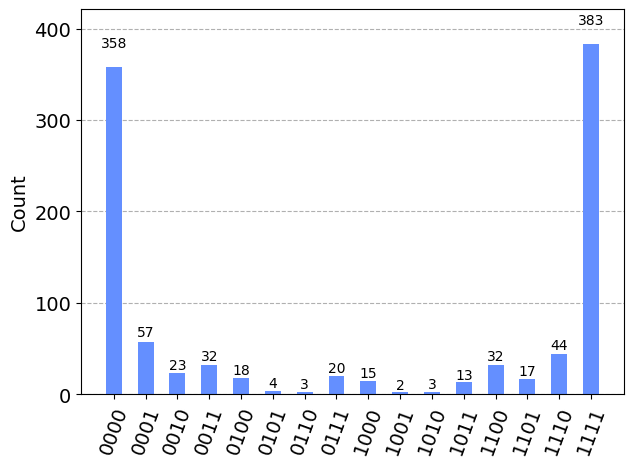

In [82]:
#Two folds
circ = basiccircuitfold(4,2)
#print(noisysimultation(circ, noise_model))
plot_histogram(noisysimultation(circ, noise_model))

We now do the extrapolation. We set the max number $MAX$ of folds and create arrays that record the probabilities of states $|00 \rangle$ and $|11 \rangle$ with $0,1, \ldots, MAX$ folds. 

In [203]:
Max_num_folds = 8


probabilities00 = []
for k in range(0, Max_num_folds):
    circ = basiccircuitfold(2,k)
    counts = noisysimultation(circ, noise_model)
    probabilities00.append(counts['00'] / sum(counts.values()))
print(probabilities00)
print('the unmitigated prob of |00> is: ', probabilities00[0])


#Extrapolate 
X = np.arange(Max_num_folds)
y = probabilities00
print(y)
reg = LinearRegression().fit(X[:, None], y)
print(reg.predict(np.array([[-1]])))

probabilities11 = []
for k in range(0, Max_num_folds):
    circ = basiccircuitfold(2,k)
    counts = noisysimultation(circ, noise_model)
    probabilities11.append(counts['11'] / sum(counts.values()))
print(probabilities11)
print('the unmitigated prob of |11> is: ', probabilities11[0])










[0.4453125, 0.408203125, 0.400390625, 0.384765625, 0.3984375, 0.3994140625, 0.396484375, 0.4150390625]
the unmitigated prob of |00> is:  0.4453125
[0.4453125, 0.408203125, 0.400390625, 0.384765625, 0.3984375, 0.3994140625, 0.396484375, 0.4150390625]
[0.41992188]
[0.427734375, 0.412109375, 0.4208984375, 0.3876953125, 0.3994140625, 0.392578125, 0.42578125, 0.40625]
the unmitigated prob of |11> is:  0.427734375
[0.427734375, 0.412109375, 0.4208984375, 0.3876953125, 0.3994140625, 0.392578125, 0.42578125, 0.40625]
[0.41737584]


**We now plot and provide our estimate of zero error limit**

The function polyfit fits our set of y values given below by probabilities00. The red star on the plot indicates the ZNE estimate of zero noise.

This is the ZNE  error mitgated estimte |00> of zero noise: 0.4890485491071428
This is the unmitigated error estimte |00>: 0.4453125


Text(0, 0.5, 'probabilities')

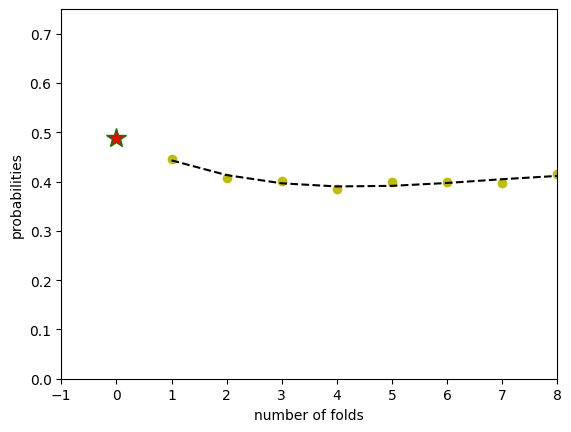

In [242]:
import matplotlib.pyplot as plt
deg = 3

x = np.arange(1,Max_num_folds+1)
y = probabilities00


coef = np.polyfit(x,y,deg)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y
print('This is the ZNE  error mitgated estimte |00> of zero noise:', poly1d_fn(0))
print('This is the unmitigated error estimte |00>:', probabilities00[0] )
plt.plot(x,y, 'yo', x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
plt.plot(poly1d_fn(0), marker="*", markersize=15, 
             markeredgecolor="green",markerfacecolor="red")

plt.xlim(-1, 8)
plt.ylim(0, .75)
plt.xlabel("number of folds")
plt.ylabel("probabilities")





